In [ ]:
%pip install datasets Pillow python-dotenv scikit-learn matplotlib

In [ ]:
from datasets import load_dataset, Image

dataset = load_dataset("ceyda/fashion-products-small", split="train")

In [ ]:
first_10_rows = dataset[:10]
dataset[0]["image"]

In [ ]:
import json
import requests
import os
from io import BytesIO
import mimetypes
from dotenv import load_dotenv
load_dotenv()

# Replace <endpoint> and <subscription-key> with your actual endpoint and subscription key
endpoint = os.getenv('VISION_ENDPOINT')
print(endpoint)
key = os.getenv('VISION_KEY')

def post_image(pil_image, file_name):
    # Determine the MIME type of the file
    img_byte_arr = BytesIO()
    pil_image.save(img_byte_arr, format=pil_image.format)
    img_byte_arr = img_byte_arr.getvalue()

    content_type, _ = mimetypes.guess_type(file_name)
    if content_type is None:
        content_type = 'application/octet-stream'

    # Check if the content type is valid
    if not content_type.startswith('image/') and content_type != 'application/octet-stream':
        raise ValueError("Unsupported content type: {}".format(content_type))

    url = f"https://{endpoint}/computervision/retrieval:vectorizeImage?api-version=2023-02-01-preview&modelVersion=latest"
    headers = {
        "Content-Type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": key
    }

    # Send the POST request
    response = requests.post(url, headers=headers, data=img_byte_arr)
    json_res = response.json()
    return json_res["vector"]

# Writing to a JSON lines document
with open('data/imagevectors.jsonl', 'w') as file:
    for i in range(1000):
        res = post_image(dataset[i]["image"], dataset[i]["filename"])
        new_obj = dataset[i].copy()
        new_obj.pop('image', None)
        new_obj["vector"] = res
        json_record = json.dumps(new_obj)
        file.write(json_record + '\n')
        print(f"Done with {i}")

In [14]:
import pandas as pd
samples = pd.read_json("data/imagevectors.jsonl", lines=True)

categories = sorted(samples["masterCategory"].unique())
print("Categories of samples:", samples["masterCategory"].value_counts())

samples.head()

Categories of samples: masterCategory
Apparel          440
Accessories      274
Footwear         230
Personal Care     50
Free Items         3
Name: count, dtype: int64


,filename,link,id,masterCategory,gender,subCategory,vector
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970,Apparel,Men,Topwear,"[1.5634766, -1.3173827999999999, 1.6083984, -2..."
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386,Apparel,Men,Bottomwear,"[-0.7026367, 1.9970702999999999, -0.15283203, ..."
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263,Accessories,Women,Watches,"[2.1699219, 1.7363281, -0.37890625, -2.7402344..."
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,21379,Apparel,Men,Bottomwear,"[-4.8828125, 4.15625, 0.9243163999999999, 0.54..."
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,53759,Apparel,Men,Topwear,"[-2.6445312, -0.4248047, 0.66015625, -1.720703..."


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
# Select only the vectors
matrix = samples.loc[:, "vector"].tolist()
# Fit and transform the vectors
vis_dims = pca.fit_transform(matrix)
# Assing a list to a new column in the dataframe
samples["embed_vis"] = vis_dims.tolist()
samples.head()

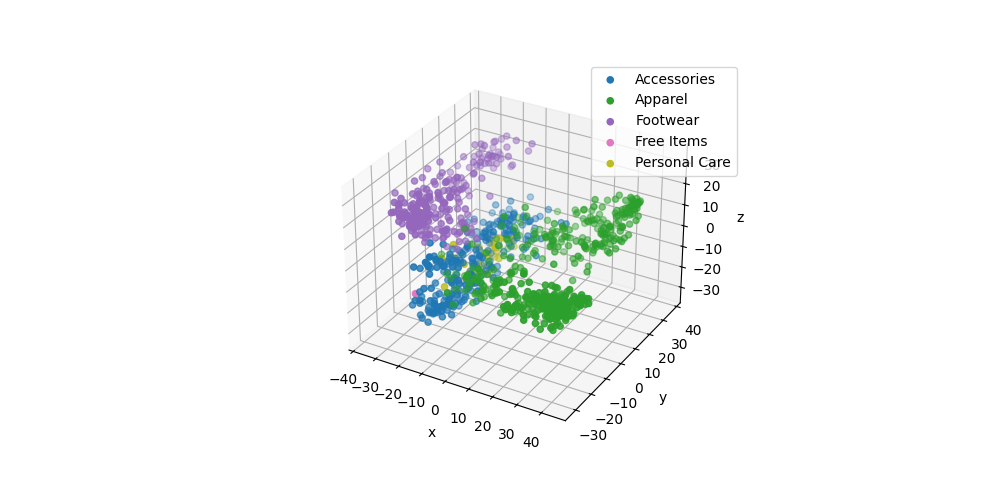

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

# Plot each sample category individually such that we can set label name.
for i, cat in enumerate(categories):
    sub_matrix = np.array(samples[samples["masterCategory"] == cat]["embed_vis"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    ax.scatter(x, y, zs=z, zdir='z', c=colors, label=cat)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.1, 1))